In [ ]:
import sys, os
import numpy as np
import csv
from datetime import datetime, timedelta
# for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('classic')
%matplotlib inline

In [15]:
edu_dir = '/Users/jihyun/research/education/'
course_id = 2755
data_dir = os.path.join(edu_dir, 'data',str(course_id))
print data_dir

/Users/jihyun/research/education/data/2755


In [8]:
first_day = datetime(2016, 9, 15, 0, 0, 0)
days_limit = 90  # total 90 days

# Load csv clickstream data

In [13]:
def get_cats_from_url(url, depth=1):

    if not 0 < depth < 4:
        raise ('ERROR! depth should be integers between 1 and 3!')

    if url.endswith('/'):
        url = url[:-1]
    url = url.replace('api/v1/', '')

    if len(url.split('/')) < 6:
        return 'homepage'


def load_csv(deidentified_data_dir):
    """
    The de-identified CSV files should have the following columns
        random_id, url_action, created_at, interaction_seconds, ip_address

    """

    print('Loading csv files')
    data = {}
    index = 0
    idx2id = []
    id2idx = {}
    ip2id = {}
    date_format = "%Y-%m-%dT%H:%M:%SZ"

    for file in os.listdir(deidentified_data_dir):
        url = []
        category = []
        action = []
        created_at = []
        interact_secs = []
        remote_ip = []

        if file.endswith('csv'):
            csv_file = os.path.join(deidentified_data_dir, file)
            csv_reader = csv.reader(open(csv_file, 'r'))
            next(csv_reader, None)
            for line in csv_reader:
                id = line[0]
                ip = line[-1]
                url.append(line[1])
                category.append(get_cats_from_url(line[1]))
                action.append(line[2])
                # you need to subtract 7 hours to get the california time
                created_at.append(datetime.strptime(line[3], date_format) - timedelta(0, 25200))
                interact_secs.append(line[4])
                remote_ip.append(ip)
                if ip2id.get(ip, None) is None:
                    ip2id[ip] = []
                if int(id) not in ip2id[ip]:
                    ip2id[ip].append(int(id))

            id = int(id)
            data[id] = {"url": url[::-1], "category": category[::-1], "action": action[::-1],
                        "created_at": created_at[::-1],
                        "interact_secs": interact_secs[::-1], "remote_ip": remote_ip[::-1]}
            id2idx[id] = index
            idx2id.append(id)
            index += 1
    n_students = index
    print('Finished Loading')
    return data, n_students, id2idx, idx2id, ip2id

In [14]:
deid_data_dir = os.path.join(data_dir, 'deidentified') # path to the deidentified click data
csv_data, n_students, id2idx, idx2id, ip2id = load_csv(deid_data_dir)

Loading csv files
Finished Loading


In [ ]:
# data checking
print csv_data.keys()
print csv_data[211456]

# Get number of clicks per day matrix

In [24]:
def get_num_clicks_per_day(student_data, days_limit, first_day, type='all'):
    """
    Parameters
    ----------
    student_data : dict
        dictionary for each student. (One entry of canvas_data.) It should have 'created_at' entry.

    Returns
    -------
        np.array
        numpy array with length 'days_limit'
        Histogram (counts) of the student as a function of time.

    """
    hist_array = np.zeros(days_limit, dtype=np.int32)
    if type == 'all':  # Default
        for time in student_data['created_at']:
            delta = time - first_day
            if delta.days < days_limit:
                hist_array[delta.days] += 1
    else:
        for i, time in enumerate(student_data['created_at']):
            cat = get_cats_from_url(student_data['url'][i], depth=1)
            if cat == type:
                delta = time - first_day
                if delta.days < days_limit:
                    hist_array[delta.days] += 1
    return hist_array


def get_num_clicks_per_day_mat(csvdata, n_students, days_limit, first_day, idx2id, type='all'):
    """
    Get (num_student X num_days) matrix
    where each row is the number of click events per day for each student.
    Returns
    -------
        np.array

    """
    clicks_per_day_mat = np.zeros((n_students, days_limit), dtype=np.int32)
    for idx, random_id in enumerate(idx2id):
        student = csvdata[random_id]
        clicks_per_day_mat[idx] = get_num_clicks_per_day(student, days_limit, first_day, type)
    return clicks_per_day_mat

In [26]:
click_mat = get_num_clicks_per_day_mat(csv_data, n_students, days_limit, first_day, idx2id)
print click_mat

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 2]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


<Container object of 90 artists>

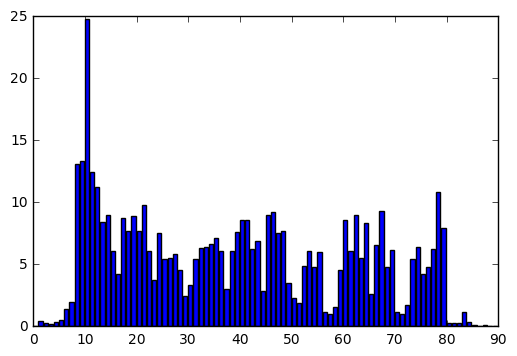

In [27]:
plt.bar(range(days_limit), np.mean(click_mat, axis=0))

# Load the quiz_url description file

In [33]:
quiz_url_file = os.path.join(data_dir, 'quiz_url_descriptions.csv')
with open(quiz_url_file, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    header = reader.next()
    for line in reader:
        q_num = line[0]
        q_name = line[1]
        q_pnts = line[2]
        q_open_date = line[3]
        break

In [34]:
q_open_date

'Sep 23, 2016 at 10:50am'

In [37]:
help(datetime.strptime)

Help on built-in function strptime:

strptime(...)
    string, format -> new datetime parsed from a string (like time.strptime()).



In [42]:
datetime.strptime(q_open_date, "%b %d, %Y at %I:%M%p")

datetime.datetime(2016, 9, 23, 10, 50)